In [2]:
# ==== 1. Import thư viện cần thiết ====
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import graphviz
from sklearn.tree import export_graphviz

# Cấu hình tên file
DATA_FILE = "DecisionTree_Gini_data.csv"
MODEL_FILE = "decision_tree_gini_pipeline.joblib"
TARGET_ENCODER_FILE = "gini_target_encoder.joblib"

In [3]:
# ==== 2. Load dữ liệu ====
# Giả sử file csv có cột đầu tiên là ID (D1, D2...), ta dùng index_col=0 để lấy nó làm index
try:
    df = pd.read_csv(DATA_FILE, index_col=0)
    print(f"Đã load thành công {len(df)} dòng dữ liệu từ file {DATA_FILE}.")
    print("-" * 50)
    print(df.head()) # In thử 5 dòng đầu để kiểm tra
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {DATA_FILE}. Vui lòng kiểm tra lại đường dẫn.")

Đã load thành công 14 dòng dữ liệu từ file DecisionTree_Gini_data.csv.
--------------------------------------------------
     Outlook Temperature Humidity    Wind Play ball
D1     Sunny         Hot     High    Weak        No
D2     Sunny         Hot     High  Strong        No
D3  Overcast         Hot     High    Weak       Yes
D4     Rainy        Mild     High    Weak       Yes
D5     Rainy        Cool   Normal    Weak       Yes


In [4]:
# ==== 3. Phân tách Features (X) và Target (y) ====
# Dựa trên sample data bạn cung cấp: Outlook, Temperature, Humidity, Wind, Play ball
target_col = "Play ball"

if target_col in df.columns:
    y = df[target_col]
    
    # Chọn đúng các cột Features theo yêu cầu, loại bỏ cột Target
    # Lưu ý: Cột ID (D1, D2) đã được đẩy vào index_col nên không cần drop thủ công nữa
    feature_cols = ["Outlook", "Temperature", "Humidity", "Wind"]
    
    # Kiểm tra xem các cột feature có tồn tại trong dữ liệu không
    existing_cols = [col for col in feature_cols if col in df.columns]
    X = df[existing_cols]
    
    print(f"\nFeatures: {list(X.columns)}")
    print(f"Target: {target_col}")

    # Xác định các cột phân loại (categorical)
    cat_cols = X.select_dtypes(include=['object']).columns

    # Mã hóa mục tiêu (Play ball: Yes/No) sang số nguyên
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    print("Classes:", target_encoder.classes_)


Features: ['Outlook', 'Temperature', 'Humidity', 'Wind']
Target: Play ball
Classes: ['No' 'Yes']


In [5]:
# ==== 4. Định nghĩa Pipeline Tiền xử lý ====
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [6]:
# ==== 5. Xây dựng Pipeline hoàn chỉnh (Sử dụng GINI) ====
# QUAN TRỌNG: criterion="gini"
model_gini = DecisionTreeClassifier(criterion="gini", random_state=42)

pipe_gini = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_gini)
])

In [7]:
# ==== 6. Chia tập train/test và Huấn luyện ====
# Do dữ liệu ít (14 dòng), test_size có thể để nhỏ hoặc điều chỉnh tùy ý
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

print(f"\nKích thước tập Train: {len(X_train)} mẫu")
print(f"Kích thước tập Test: {len(X_test)} mẫu")

pipe_gini.fit(X_train, y_train)
print("Đã huấn luyện xong mô hình Gini.")


Kích thước tập Train: 9 mẫu
Kích thước tập Test: 5 mẫu
Đã huấn luyện xong mô hình Gini.


In [8]:
# ==== 7. Đánh giá mô hình ====
y_pred = pipe_gini.predict(X_test)
y_test_labels = target_encoder.inverse_transform(y_test)
y_pred_labels = target_encoder.inverse_transform(y_pred)

print("\n" + "="*20 + " KẾT QUẢ ĐÁNH GIÁ (GINI) " + "="*20)
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))
print("="*65)


==================== KẾT QUẢ ĐÁNH GIÁ (GINI) ====================
Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

          No       0.50      0.50      0.50         2
         Yes       0.67      0.67      0.67         3

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5


Confusion Matrix:
 [[1 1]
 [1 2]]


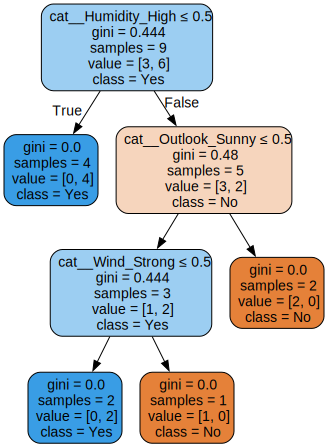

In [9]:
# ==== 8. Xuất hình cây quyết định ====
# Cập nhật đường dẫn Graphviz của bạn tại đây nếu cần thiết
os.environ["PATH"] += os.pathsep + r"E:\Program\Graphviz\bin"

try:
    # Lấy tên feature sau khi OneHotEncoding
    ohe_feature_names = pipe_gini.named_steps['preprocessor'].get_feature_names_out()

    dot_data = export_graphviz(
        pipe_gini.named_steps['classifier'],
        out_file=None,
        feature_names=ohe_feature_names,
        class_names=target_encoder.classes_,
        filled=True,
        rounded=True,
        special_characters=True,
        impurity=True # Hiển thị chỉ số Gini
    )

    graph = graphviz.Source(dot_data)
    from IPython.display import display
    display(graph)
    
except Exception as e:
    print(f"Không thể hiển thị hình ảnh cây quyết định. Lỗi: {e}")

In [10]:
# ==== 9. Lưu model ====
joblib.dump(pipe_gini, MODEL_FILE)
joblib.dump(target_encoder, TARGET_ENCODER_FILE)

print(f"\nPipeline model (Gini) đã được lưu → {MODEL_FILE}")
print(f"Target Encoder đã được lưu → {TARGET_ENCODER_FILE}")


Pipeline model (Gini) đã được lưu → decision_tree_gini_pipeline.joblib
Target Encoder đã được lưu → gini_target_encoder.joblib
